In [13]:
!pip install datasets

In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from datasets import load_dataset

# specify GPU
device = torch.device("cuda")

#Load dataset

In [15]:
!unzip /content/data-20240129T214509Z-001.zip

Archive:  /content/data-20240129T214509Z-001.zip
replace data/WP_eval_data_for_practice.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/WP_eval_data_for_practice.npy  
  inflating: data/SP-train.npy       
  inflating: data/SP_eval_data_for_practice.npy  
  inflating: data/WP-train.npy       


In [16]:
raw_data = np.load('/content/data/SP-train.npy', allow_pickle=True)

In [17]:
raw_data[0]

{'id': 'SP-0',
 'question': 'Mr. and Mrs. Mustard have six daughters and each daughter has one brother. But there are only 9 people in the family, how is that possible?',
 'answer': 'Each daughter shares the same brother.',
 'distractor1': 'Some daughters get married and have their own family.',
 'distractor2': 'Some brothers were not loved by family and moved away.',
 'distractor(unsure)': 'None of above.',
 'label': 1,
 'choice_list': ['Some daughters get married and have their own family.',
  'Each daughter shares the same brother.',
  'Some brothers were not loved by family and moved away.',
  'None of above.'],
 'choice_order': [1, 0, 2, 3]}

In [18]:
data = {
    'question':[],
    'answer1':[],
    'answer2':[],
    'answer3':[],
    'label':[]
}
for item in raw_data:
  data['question'].append(item['question'])
  data['answer1'].append(item['choice_list'][0])
  data['answer2'].append(item['choice_list'][1])
  data['answer3'].append(item['choice_list'][2])
  data['label'].append(item['choice_order'][0])

In [19]:
df = pd.DataFrame(data)
df

,question,answer1,answer2,answer3,label
0,Mr. and Mrs. Mustard have six daughters and ea...,Some daughters get married and have their own ...,Each daughter shares the same brother.,Some brothers were not loved by family and mov...,1
1,The six daughters of Mr. and Mrs. Mustard each...,Some brothers were not loved by family and mov...,Some daughters get married and have their own ...,Each daughter shares the same brother.,2
2,"A chess team has five players, and each player...",Each player shares the same coach.,Some players are backups and not allowed to play.,Some coaches get a raise.,0
3,A woman shoots her husband. Then she holds him...,The woman gets arrested for murder after dinner.,The woman gets a new partner.,The woman was a photographer. She shot a pictu...,1
4,An individual shoots their spouse. She continu...,The woman gets arrested for murder after dinner.,The woman was a photographer. She shot a pictu...,The woman gets a new partner.,1
...,...,...,...,...,...
502,"Ten pears hung high, ten men passed past, Each...",Other men can't reach the pear.,Other men didn't see the pear.,EACH is the name of one of the men.,1
503,There were twenty boys with different names in...,Other boys don't have names.,All is the name of one of the boys.,Other boys don't know how to write.,2
504,"The more you take, the more you leave behind",Love.,Footsteps.,Money.,1
505,"The more you take, the more you abandon.",Love.,Footsteps.,Money.,1


In [20]:
# check class distribution
df['label'].value_counts(normalize = True)

1    0.347140
2    0.321499
0    0.291913
3    0.039448
Name: label, dtype: float64

In [21]:
# split train dataset into train, validation and test sets
train_text, test_text, train_labels, test_labels = train_test_split(df[['question','answer1','answer2','answer3']], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.1,
                                                                    stratify=df['label'])


In [22]:
train_text.to_csv('train.csv')
test_text.to_csv('test.csv')

In [23]:
whole_data = load_dataset(
    "csv",
    data_files={
        "train": "train.csv",
        "test": "test.csv",
    },
)

print(whole_data)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'question', 'answer1', 'answer2', 'answer3'],
        num_rows: 456
    })
    test: Dataset({
        features: ['Unnamed: 0', 'question', 'answer1', 'answer2', 'answer3'],
        num_rows: 51
    })
})


In [24]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [25]:
def tokenize_text(batch):
    opt1 = tokenizer(batch["question"], batch['answer1'], truncation=True, pad_to_max_length=True, max_length= 100)
    opt2 = tokenizer(batch["question"], batch['answer2'], truncation=True, pad_to_max_length=True, max_length= 100)
    opt3 = tokenizer(batch["question"], batch['answer3'], truncation=True, pad_to_max_length=True, max_length= 100)
    return {'option1': opt1,'option2': opt2, 'option3': opt3}

In [26]:
my_tokenized = whole_data.map(tokenize_text)

Map:   0%|          | 0/456 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Map:   0%|          | 0/51 [00:00<?, ? examples/s]

In [27]:
my_tokenized

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'question', 'answer1', 'answer2', 'answer3', 'option1', 'option2', 'option3'],
        num_rows: 456
    })
    test: Dataset({
        features: ['Unnamed: 0', 'question', 'answer1', 'answer2', 'answer3', 'option1', 'option2', 'option3'],
        num_rows: 51
    })
})

In [28]:
print(tokenizer.decode(my_tokenized['train'][0]['option1']['input_ids']))
print(tokenizer.decode(my_tokenized['train'][0]['option2']['input_ids']))
print(tokenizer.decode(my_tokenized['train'][0]['option3']['input_ids']))

[CLS] what animal has no wings, but yet will fly? [SEP] an elephant. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] what animal has no wings, but yet will fly? [SEP] a caterpillar. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [29]:
train_seq = torch.tensor([[sample['option1']['input_ids'], sample['option2']['input_ids'], sample['option3']['input_ids']] for sample in my_tokenized['train']])
train_mask = torch.tensor([[sample['option1']['attention_mask'], sample['option2']['attention_mask'], sample['option3']['attention_mask']] for sample in my_tokenized['train']])
train_y = torch.tensor(train_labels.tolist())

test_seq = torch.tensor([[sample['option1']['input_ids'], sample['option2']['input_ids'], sample['option3']['input_ids']] for sample in my_tokenized['test']])
test_mask = torch.tensor([[sample['option1']['attention_mask'], sample['option2']['attention_mask'], sample['option3']['attention_mask']] for sample in my_tokenized['test']])
test_y = torch.tensor(test_labels.tolist())

In [30]:
print(train_seq.shape)
print(train_mask.shape)
print(train_y.shape)

print(test_seq.shape)
print(test_mask.shape)
print(test_y.shape)

torch.Size([456, 3, 100])
torch.Size([456, 3, 100])
torch.Size([456])
torch.Size([51, 3, 100])
torch.Size([51, 3, 100])
torch.Size([51])


In [31]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for testidation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [32]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert
        for param in self.bert.parameters():
          param.requires_grad = False
        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(3*768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,4)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs1 = self.bert(sent_id[:,0,:], attention_mask=mask[:,0,:], return_dict=False)
        _, cls_hs2 = self.bert(sent_id[:,1,:], attention_mask=mask[:,1,:], return_dict=False)
        _, cls_hs3 = self.bert(sent_id[:,2,:], attention_mask=mask[:,2,:], return_dict=False)
        # x1 = self.fc1(cls_hs1)
        # x2 = self.fc1(cls_hs2)
        # x3 = self.fc1(cls_hs3)
        cls_hs = torch.cat([cls_hs1, cls_hs2, cls_hs3], axis=1)

        x = self.fc1(cls_hs)
        # x = torch.cat([x1,x2,x3], axis=1)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [33]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [34]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print('Class Weights:',class_weights)

Class Weights: [0.85714286 0.72151899 0.7755102  6.33333333]


In [36]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)


In [37]:
# function to train the model
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [38]:
import time

# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(test_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            # elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(test_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


In [39]:
# set initial loss to infinite
best_valid_loss = float('inf')

#defining epochs
epochs = 20

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20

Evaluating...

Training Loss: 1.387
Validation Loss: 1.363

 Epoch 2 / 20

Evaluating...

Training Loss: 1.369
Validation Loss: 1.349

 Epoch 3 / 20

Evaluating...

Training Loss: 1.360
Validation Loss: 1.344

 Epoch 4 / 20

Evaluating...

Training Loss: 1.350
Validation Loss: 1.339

 Epoch 5 / 20

Evaluating...

Training Loss: 1.340
Validation Loss: 1.336

 Epoch 6 / 20

Evaluating...

Training Loss: 1.340
Validation Loss: 1.338

 Epoch 7 / 20

Evaluating...

Training Loss: 1.329
Validation Loss: 1.331

 Epoch 8 / 20

Evaluating...

Training Loss: 1.330
Validation Loss: 1.328

 Epoch 9 / 20

Evaluating...

Training Loss: 1.318
Validation Loss: 1.325

 Epoch 10 / 20

Evaluating...

Training Loss: 1.328
Validation Loss: 1.321

 Epoch 11 / 20

Evaluating...

Training Loss: 1.316
Validation Loss: 1.322

 Epoch 12 / 20

Evaluating...

Training Loss: 1.320
Validation Loss: 1.324

 Epoch 13 / 20

Evaluating...

Training Loss: 1.312
Validation Loss: 1.326

 Epoch 14 / 20

Eval

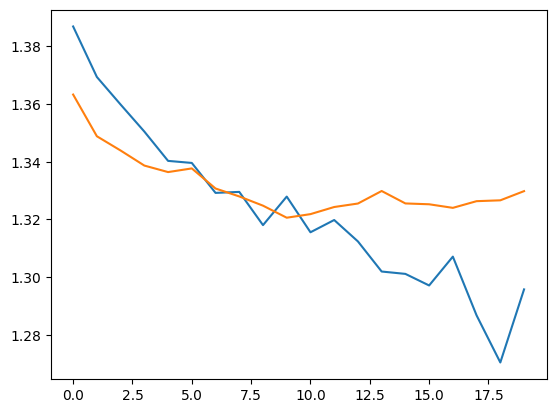

In [40]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [41]:
model.load_state_dict(torch.load('saved_weights.pt'))
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()


# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.25      0.40      0.31        15
           1       0.40      0.44      0.42        18
           2       0.50      0.19      0.27        16
           3       1.00      0.50      0.67         2

    accuracy                           0.35        51
   macro avg       0.54      0.38      0.42        51
weighted avg       0.41      0.35      0.35        51



In [42]:
test_nolabel = np.load('SP_new_test.npy', allow_pickle=True)

In [43]:
data = {
    'question':[],
    'answer1':[],
    'answer2':[],
    'answer3':[]
}
for item in test_nolabel:
  data['question'].append(item['question'])
  data['answer1'].append(item['choice_list'][0])
  data['answer2'].append(item['choice_list'][1])
  data['answer3'].append(item['choice_list'][2])

df = pd.DataFrame(data)
df.to_csv('test_nolabel.csv')

whole_data = load_dataset(
    "csv",
    data_files={
        "test": "test_nolabel.csv"
    },
)

print(whole_data)

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['Unnamed: 0', 'question', 'answer1', 'answer2', 'answer3'],
        num_rows: 120
    })
})


In [44]:
test_tokenized = whole_data.map(tokenize_text)

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [45]:
tst_seq = torch.tensor([[sample['option1']['input_ids'], sample['option2']['input_ids'], sample['option3']['input_ids']] for sample in test_tokenized['test']])
tst_mask = torch.tensor([[sample['option1']['attention_mask'], sample['option2']['attention_mask'], sample['option3']['attention_mask']] for sample in test_tokenized['test']])


In [46]:
print(tst_seq.shape)
print(tst_mask.shape)

torch.Size([120, 3, 100])
torch.Size([120, 3, 100])


In [47]:
model.load_state_dict(torch.load('saved_weights.pt'))

with torch.no_grad():
  for seq, mask in zip(tst_seq, tst_mask):
    preds = model(seq.unsqueeze(dim=0).to(device), mask.unsqueeze(dim=0).to(device))
    preds = preds.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    print(preds[0])


1
1
3
3
1
0
0
3
2
0
1
2
0
0
0
0
0
1
1
0
0
0
0
0
0
3
0
1
0
2
1
0
1
2
0
1
0
0
0
0
0
1
0
3
3
1
0
0
0
1
1
2
1
0
1
0
1
1
2
1
0
0
0
0
3
0
1
2
2
0
0
0
0
2
1
0
1
1
2
0
0
0
0
1
0
0
0
0
0
2
0
1
1
0
1
0
0
1
1
0
1
0
0
1
0
0
3
1
1
0
1
3
0
0
0
0
0
1
0
0
